cifar10 patch reconstruction using stochastic interpolants

this implementation:
- trains on dog class only (cifar10 class 5)
- uses mask-conditioned u-net architecture
- learns to reconstruct masked patches while keeping visible pixels fixed
- conditions on mask during both training and generation
- forces visible pixels to remain constant in output

approach:
  x0 = masked_image * mask + noise * (1-mask)  # we start with visible pixels + noise in masked regions
  x1 = original_image                           # we target full image
  model learns interpolant: x0 -> x1 conditioned on mask
  during generation: output = model_output * (1-mask) + original * mask  # we force visible pixels fixed

## **0 - Installations de base :**

In [4]:
# Installations :

!pip install torchdiffeq

## **1 - Outils pratiques :**

In [5]:
# Imports :

import numpy as np
import torch
import hashlib
import math
import os
from dataclasses import dataclass
from typing import Callable, Any, Tuple
from torchdiffeq import odeint_adjoint as odeint
from torch import vmap
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../../')


In [6]:
# Fonction qui convertit des tenseurs PyTorch en tableau NumPy :

def grab(var):
  """we take a tensor off the gpu and convert it to a numpy array on the cpu"""
    if hasattr(var, 'detach'):
        return var.detach().cpu().numpy()
    else:
        return

In [7]:
# Fonction qui initialise les poids du modèle :

def init_weights(layers, init_weights_type, init_weights_type_cfg):
    if init_weights_type is not None:
        initializer = getattr(torch.nn.init, init_weights_type)
        def save_init(m):
            if type(m) != torch.nn.BatchNorm3d and hasattr(m, 'weight') and m.weight is not None:
                initializer(m.weight, **init_weights_type_cfg)
            if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.zeros_(m.bias) # bias always zeros

        layers.apply(save_init)
        print("Weights initialization done:", initializer, init_weights_type_cfg)

In [8]:
# Fonction qui calcule la quantité de padding nécessaire :

def circ_padding_size(kernel_size):
    torch_version = version.parse(torch.__version__)
    version_150 = version.parse('1.5.0')
    if torch_version < version_150:
        return kernel_size - 1
    else: # for pytorch >= 1.5
        assert kernel_size % 2 == 1, 'circ padding only support for odd kernel size'
        return kernel_size // 2

In [9]:
# Fonction qui sert à identifier le modèle :

def hash_model_parameters(model):
    state_dict = model.state_dict()
    hasher = hashlib.sha1()
    for sdk in sorted(state_dict.keys()): # conventional order
        to_hash = grab(state_dict[sdk]) # get as numpy array
        hasher.update(to_hash.data.tobytes()) # all data [vs str(arr)]
    return hasher.digest() # printable

In [10]:
# Variables globales :

_device = 'cpu'
_float_dtype = np.float32

In [11]:
# Fonctions qui gèrent le placement par défaut des tenseurs :

def set_torch_device(device):
    global _device
    _device = device
    update_torch_default_tensor_type()

def get_torch_device():
    return _device

def update_torch_default_tensor_type():
    if get_torch_device() == 'cpu':
        if get_float_dtype() == np.float32:
            torch.set_default_tensor_type(torch.FloatTensor)
        elif get_float_dtype() == np.float64:
            torch.set_default_tensor_type(torch.DoubleTensor)
        else:
            raise NotImplementedError(f'Unknown float dtype {get_float_dtype()}')
    elif get_torch_device() == 'cuda':
        if get_float_dtype() == np.float32:
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
        elif get_float_dtype() == np.float64:
            torch.set_default_tensor_type(torch.cuda.DoubleTensor)
        else:
            raise NotImplementedError(f'Unknown float dtype {get_float_dtype()}')
    elif get_torch_device() == 'cuda:1':
        if get_float_dtype() == np.float32:
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
        elif get_float_dtype() == np.float64:
            torch.set_default_tensor_type(torch.cuda.DoubleTensor)
        else:
            raise NotImplementedError(f'Unknown float dtype {get_float_dtype()}')
    elif get_torch_device() == 'xpu':
        import torch_ipex
        if get_float_dtype() == np.float32:
            torch.set_default_tensor_type(torch.xpu.FloatTensor)
        elif get_float_dtype() == np.float64:
            torch.set_default_tensor_type(torch.xpu.DoubleTensor)
        else:
            raise NotImplementedError(f'Unknown float dtype {get_float_dtype()}')
    else:
        raise NotImplementedError(f'Unknown device {get_torch_device()}')

In [12]:
# Fonctions qui servent à gérer la précision des nombres flottants :

def get_float_dtype():
    return _float_dtype

def set_float_dtype(np_dtype):
    global _float_dtype
    _float_dtype = np_dtype
    update_torch_default_tensor_type()

def get_float_torch_dtype():
    if _float_dtype == np.float32:
        return torch.float32
    elif _float_dtype == np.float64:
        return torch.float64
    else:
        raise NotImplementedError(f'unknown np dtype {_float_dtype}')

def get_complex_torch_dtype():
    if _float_dtype == np.float32:
        return torch.complex64
    elif _float_dtype == np.float64:
        return torch.complex128
    else:
        raise NotImplementedError(f'unknown np dtype {_float_dtype}')

def set_float_prec(prec):
    if prec == 'single':
        set_float_dtype(np.float32)
    elif prec == 'double':
        set_float_dtype(np.float64)
    else:
        raise NotImplementedError(f'Unknown precision type {prec}')

In [13]:
# Fonction qui choisit le meilleur device :

def init_device():
    if torch.cuda.is_available():
        set_torch_device('cuda')
        return 'cuda'
    try:
        import torch_ipex
        if torch.xpu.is_available():
            set_torch_device('xpu')
            return 'xpu'
    except:
        pass
    return 'cpu'

## **2 - Création du champ de vitesse :**

In [ ]:
# Ajoute le temps comme entrée du réseau :

class InputWrapper(torch.nn.Module):
    def __init__(self, v):
        super(InputWrapper, self).__init__()
        self.v = v

    def net_inp(
        self,
        t: torch.tensor,  # [1]
        x: torch.tensor   # [batch x dim]
    ) -> torch.tensor:    # [batch x (1 + dim)]
        """Concatenate time over the batch dimension."""
        inp = torch.cat((t.repeat(x.shape[0]).unsqueeze(1), x), dim = 1)
        return inp

    def forward(self, x, t):
        tx = self.net_inp(t,x)
        return self.v(tx)

In [ ]:
# Création du modèle de champ de vitesse :

def make_fc_net(hidden_sizes, in_size, out_size, inner_act, final_act, **config):
    sizes = [in_size] + hidden_sizes + [out_size]
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Linear(
            sizes[i], sizes[i+1]))
        if i != len(sizes) - 2:
            net.append(make_activation(inner_act))
            continue
        else:
            if make_activation(final_act):
                net.append(make_activation(final_act))

    v_net = torch.nn.Sequential(*net)
    return InputWrapper(v_net)

In [ ]:
# Création du chemin d'interpolation :

def make_It(path='linear', gamma = None, gamma_dot = None, gg_dot = None):
    """gamma function must be specified if using the trigonometric interpolant"""

    if path == 'linear':


        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'trig':
        if gamma == None:
            raise TypeError("Gamma function must be provided for trigonometric interpolant!")
        a    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)
        b    = lambda t: torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        adot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t) \
                                - 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t)
        bdot = lambda t: -gg_dot(t)/torch.sqrt(1 - gamma(t)**2)*torch.sin(0.5*math.pi*t) \
                                + 0.5*math.pi*torch.sqrt(1 - gamma(t)**2)*torch.cos(0.5*math.pi*t)

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'encoding-decoding':

        a    = lambda t: torch.where(t <= 0.5, torch.cos(math.pi*t)**2, torch.tensor(0.))
        adot = lambda t: torch.where(t <= 0.5, -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        b    = lambda t: torch.where(t > 0.5,  torch.cos(math.pi*t)**2, 0.)
        bdot = lambda t: torch.where(t > 0.5,  -2*math.pi*torch.cos(math.pi*t)*torch.sin(math.pi*t), torch.tensor(0.))
        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-linear':

        a      = lambda t: (1-t)
        adot   = lambda t: -1.0
        b      = lambda t: t
        bdot   = lambda t: 1.0

        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'one-sided-trig':

        a      = lambda t: torch.cos(0.5*math.pi*t)
        adot   = lambda t: -0.5*math.pi*torch.sin(0.5*math.pi*t)
        b      = lambda t: torch.sin(0.5*math.pi*t)
        bdot   = lambda t: 0.5*math.pi*torch.cos(0.5*math.pi*t)


        It   = lambda t, x0, x1: a(t)*x0 + b(t)*x1
        dtIt = lambda t, x0, x1: adot(t)*x0 + bdot(t)*x1

    elif path == 'mirror':
        if gamma == None:
            raise TypeError("Gamma function must be provided for mirror interpolant!")

        a     = lambda t: gamma(t)
        adot  = lambda t: gamma_dot(t)
        b     = lambda t: torch.tensor(1.0)
        bdot  = lambda t: torch.tensor(0.0)

        It    = lambda t, x0, x1: b(t)*x1 + a(t)*x0
        dtIt  = lambda t, x0, x1: adot(t)*x0

    elif path == 'custom':
        return None, None, None

    else:
        raise NotImplementedError("The interpolant you specified is not implemented.")


    return It, dtIt, (a, adot, b, bdot)

In [ ]:
# Contrôle la forme du chemin entre deux images :

def make_gamma(gamma_type = 'brownian', aval = None):
    """
    returns callable functions for gamma, gamma_dot,
    and gamma(t)*gamma_dot(t) to avoid numerical divide by 0s,
    e.g. if one is using the brownian (default) gamma.
    """
    if gamma_type == 'brownian':
        gamma = lambda t: torch.sqrt(t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(t*(1-t)))) * (1 -2*t)
        gg_dot = lambda t: (1/2)*(1-2*t)

    elif gamma_type == 'a-brownian':
        gamma = lambda t: torch.sqrt(a*t*(1-t))
        gamma_dot = lambda t: (1/(2*torch.sqrt(a*t*(1-t)))) * a*(1 -2*t)
        gg_dot = lambda t: (a/2)*(1-2*t)

    elif gamma_type == 'zero':
        gamma = gamma_dot = gg_dot = lambda t: torch.zeros_like(t)

    elif gamma_type == 'bsquared':
        gamma = lambda t: t*(1-t)
        gamma_dot = lambda t: 1 -2*t
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sinesquared':
        gamma = lambda t: torch.sin(math.pi * t)**2
        gamma_dot = lambda t: 2*math.pi*torch.sin(math.pi * t)*torch.cos(math.pi*t)
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == 'sigmoid':
        f = torch.tensor(10.0)
        gamma = lambda t: torch.sigmoid(f*(t-(1/2)) + 1) - torch.sigmoid(f*(t-(1/2)) - 1) - torch.sigmoid((-f/2) + 1) + torch.sigmoid((-f/2) - 1)
        gamma_dot = lambda t: (-f)*( 1 - torch.sigmoid(-1 + f*(t - (1/2))) )*torch.sigmoid(-1 + f*(t - (1/2)))  + f*(1 - torch.sigmoid(1 + f*(t - (1/2)))  )*torch.sigmoid(1 + f*(t - (1/2)))
        gg_dot = lambda t: gamma(t)*gamma_dot(t)

    elif gamma_type == None:
        gamma     = lambda t: torch.zeros(1) ### no gamma
        gamma_dot = lambda t: torch.zeros(1) ### no gamma
        gg_dot    = lambda t: torch.zeros(1) ### no gamma

    else:
        raise NotImplementedError("The gamma you specified is not implemented.")


    return gamma, gamma_dot, gg_dot

In [14]:
# Choisir la fonction d'activation :

def make_activation(act):
    if act == 'elu':
        return torch.nn.ELU()
    if act == 'leaky_relu':
        return torch.nn.LeakyReLU()
    elif act == 'elu':
        return torch.nn.ELU()
    elif act == 'relu':
        return torch.nn.ReLU()
    elif act == 'tanh':
        return torch.nn.Tanh()
    elif act =='sigmoid':
        return torch.nn.Sigmoid()
    elif act == 'softplus':
        return torch.nn.Softplus()
    elif act == 'silu':
        return torch.nn.SiLU()
    elif act == 'Sigmoid2Pi':
        class Sigmoid2Pi(torch.nn.Sigmoid):
            def forward(self, input):
                return 2*np.pi*super().forward(input) - np.pi
        return Sigmoid2Pi()
    elif act == 'none' or act is None:
        return None
    else:
        raise NotImplementedError(f'Unknown activation function {act}')

## **3 - Équations du mouvement de l’image et entraînement du modèle :**

In [ ]:
# Fonction qui calcule la divergence :

def compute_div(
    f: Callable[[Time, Sample], torch.tensor],
    x: torch.tensor,
    t: torch.tensor  # [batch x dim]
) -> torch.tensor:
    """Compute the divergence of f(x,t) with respect to x, assuming that x is batched. Assumes data is [bs, d]"""
    bs = x.shape[0]
    with torch.set_grad_enabled(True):
        x.requires_grad_(True)
        t.requires_grad_(True)
        f_val = f(x, t)
        divergence = 0.0
        for i in range(x.shape[1]):
            divergence += \
                    torch.autograd.grad(
                            f_val[:, i].sum(), x, create_graph=True
                        )[0][:, i]

    return divergence.view(bs)

In [ ]:
# Classe permettant de transformer un modèle de bruit en un modèle de score :

class SFromEta(torch.nn.Module):
    """Class for turning a noise model into a score model."""
    def __init__(
        self,
        eta: Callable[[Sample, Time], torch.tensor],
        gamma: Callable[[Time], torch.tensor],
    ) -> None:
        super(SFromEta, self).__init__()
        self.eta = eta
        self.gamma = gamma

    def forward(self, x, t):
        val = (self.eta(x,t) / self.gamma(t))
        return val

In [ ]:
# Classe permettant de transformer un modèle de vitesse et un modèle de score en un modèle de drift :

class BFromVS(torch.nn.Module):

    """
    Class for turning a velocity model $v$ and a score model $s$ into a drift model $b$.
    If one-sided interpolation, gg_dot should be replaced with alpha*alpha_dot.
    """
    def __init__(
        self,
        v: Callable[[Sample, Time], torch.tensor],
        s: Callable[[Sample, Time], torch.tensor],
        gg_dot: Callable[[Time], torch.tensor],
    ) -> None:
        super(BFromVS, self).__init__()
        self.v = v
        self.s = s
        self.gg_dot = gg_dot


    def forward(self, x, t):
        return self.v(x, t) - self.gg_dot(t)*self.s(x, t)

In [ ]:
# Classe concernant l'interpolant :

class Interpolant(torch.nn.Module):
    """
    Class for all things interpolant $x_t = I_t(x_0, x_1) + \gamma(t)z.
    If path is one-sided, then interpolant constructs x_t = a(t) x_0 + b(t) x_1 with x_0 ~ N(0,1).

    path: str,    what type of interpolant to use, e.g. 'linear' for linear interpolant. see fabrics for options
    gamma_type:   what type of gamma function to use, e.g. 'brownian' for $\gamma(t) = \sqrt{t(1-t)}
    """
    def __init__(
        self,
        path: str,
        gamma_type: str,
        gamma: Callable[[Time], torch.tensor]          = None,
        gamma_dot: Callable[[Time], torch.tensor]      = None,
        gg_dot: Callable[[Time], torch.tensor]         = None,
        It: Callable[[Time, Sample, Sample], Sample]   = None,
        dtIt: Callable[[Time, Sample, Sample], Sample] = None
    ) -> None:
        super(Interpolant, self).__init__()


        self.path = path
        if gamma == None:
            if self.path == 'one-sided-linear' or self.path == 'one-sided-trig': gamma_type = None
            self.gamma, self.gamma_dot, self.gg_dot = make_gamma(gamma_type=gamma_type)
        else:
            self.gamma, self.gamma_dot, self.gg_dot = gamma, gamma_dot, gg_dot
        if self.path == 'custom':
            print('Assuming interpolant was passed in directly...')
            self.It = It
            self.dtIt = dtIt
            assert self.It != None
            assert self.dtIt != None


        self.It, self.dtIt, ab = make_It(path, self.gamma, self.gamma_dot, self.gg_dot)
        self.a, self.adot, self.b, self.bdot = ab[0], ab[1], ab[2], ab[3]


    def calc_xt(self, t: Time, x0: Sample, x1: Sample):
        if self.path=='one-sided-linear' or self.path == 'mirror' or self.path=='one-sided-trig':
            return self.It(t, x0, x1)
        else:
            z = torch.randn(x0.shape).to(t)
            return self.It(t, x0, x1) + self.gamma(t)*z, z


    def calc_antithetic_xts(self, t: Time, x0: Sample, x1: Sample):
        """
        Used if estimating the score and not the noise (eta).
        """
        if self.path=='one-sided-linear' or self.path == 'one-sided-trig':
            It_p = self.b(t)*x1 + self.a(t)*x0
            It_m = self.b(t)*x1 - self.a(t)*x0
            return It_p, It_m, x0
        else:
            z   = torch.randn(x0.shape).to(t)
            gam = self.gamma(t)
            It  = self.It(t, x0, x1)
            return It + gam*z, It - gam*z, z


    def forward(self, _):
        raise NotImplementedError("No forward pass for interpolant.")

In [ ]:
# Classe servant à intégrer l'ODE :

class PFlowRHS(torch.nn.Module):
    def __init__(self, b: Velocity, interpolant: Interpolant, sample_only=False):
        super(PFlowRHS, self).__init__()
        self.b = b
        self.interpolant = interpolant
        self.sample_only = sample_only


    def setup_rhs(self):
        def rhs(x: torch.tensor, t: torch.tensor):
            self.b.to(x)

            t = t.unsqueeze(0)
            return self.b(x,t)

        self.rhs = rhs


    def forward(self, t: torch.tensor, states: Tuple):
        x = states[0]
        if self.sample_only:
            return (self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (self.rhs(x, t), -compute_div(self.rhs, x, t))

    def reverse(self, t: torch.tensor, states: Tuple):
        x = states[0]
        if self.sample_only:
            return (-self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (-self.rhs(x, t), compute_div(self.rhs, x, t))



@dataclass
class PFlowIntegrator:
    b: Velocity
    method: str
    interpolant: Interpolant
    start_end: tuple = (0.0, 1.0)
    n_step: int = 5
    atol: torch.tensor = 1e-5
    rtol: torch.tensor = 1e-5
    sample_only: bool  = False
    mirror:      bool  = False


    def __post_init__(self) -> None:
        if self.mirror:
            self.rhs = MirrorPFlowRHS(s=self.b, interpolant=self.interpolant, sample_only=self.sample_only)
        else:
            self.rhs = PFlowRHS(b=self.b, interpolant=self.interpolant, sample_only=self.sample_only)
        self.rhs.setup_rhs()

        self.start, self.end = self.start_end[0], self.start_end[1]


    def rollout(self, x0: Sample, reverse=False):
        if reverse:
            integration_times = torch.linspace(self.end, self.start, self.n_step).to(x0)
        else:
            integration_times = torch.linspace(self.start, self.end, self.n_step).to(x0)
        dlogp = torch.zeros(x0.shape[0]).to(x0)

        state = odeint(
            self.rhs,
            (x0, dlogp),
            integration_times,
            method=self.method,
            atol=[self.atol, self.atol],
            rtol=[self.rtol, self.rtol]
        )

        x, dlogp = state
        return x, dlogp

In [15]:
# Classes servant à intégrer la SDE :

class MirrorPFlowRHS(torch.nn.Module):
    def __init__(self, s: Velocity, interpolant: Interpolant, sample_only=False):
        super(MirrorPFlowRHS, self).__init__()
        self.s = s
        self.interpolant = interpolant
        self.sample_only = sample_only


    def setup_rhs(self):
        def rhs(x: torch.tensor, t: torch.tensor):
            # tx = net_inp(t, x)
            self.s.to(x)

            t = t.unsqueeze(0)
            return self.interpolant.gg_dot(t)*self.s(x,t)

        self.rhs = rhs


    def forward(self, t: torch.tensor, states: Tuple):
        x = states[0]
        if self.sample_only:
            return (self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (self.rhs(x, t), -compute_div(self.rhs, x, t))

    def reverse(self, t: torch.tensor, states: Tuple):
        x = states[0]
        if self.sample_only:
            return (-self.rhs(x, t), torch.zeros(x.shape[0]).to(x))
        else:
            return (-self.rhs(x, t), compute_div(self.rhs, x, t))

@dataclass
class SDEIntegrator:
    b: Velocity
    s: Score
    eps: torch.tensor
    interpolant: Interpolant
    n_save: int = 4
    start_end: tuple = (0, 1)
    n_step: int = 100
    n_likelihood: int = 1


    def __post_init__(self) -> None:
        """Initialize forward dynamics, reverse dynamics, and likelihood."""

        def bf(x: torch.tensor, t: torch.tensor):
            """Forward drift. Assume x is batched but t is not."""
            self.b.to(x)
            self.s.to(x) ### needed to make lightning work. arises because using __post_init__
            return self.b(x,t) + self.eps*self.s(x,t)


        def br(x: torch.tensor, t: torch.tensor):
            """Backwards drift. Assume x is batched but t is not."""
            self.b.to(x)
            self.s.to(x) ### needed to make lightning work. arises because using __post_init__
            with torch.no_grad():
                return self.b(x,t) - self.eps*self.s(x,t)


        def dt_logp(x: torch.tensor, t: torch.tensor):
            """Time derivative of the log-likelihood, assumed integrating from 1 to 0.
            Assume x is batched but t is not.
            """
            score  = self.s(x,t)
            s_norm = torch.linalg.norm(score, axis=-1)**2
            return -(compute_div(self.bf, x, t) + self.eps*s_norm)


        self.bf = bf
        self.br = br
        self.dt_logp = dt_logp
        self.start, self.end = self.start_end[0], self.start_end[1]
        self.ts = torch.linspace(self.start, self.end, self.n_step)
        self.dt = (self.ts[1] - self.ts[0])



    def step_forward_heun(self, x: Sample, t: torch.tensor) -> Sample:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW   = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        xhat = x + torch.sqrt(2*self.eps)*dW
        K1   = self.bf(xhat, t + self.dt)
        xp   = xhat + self.dt*K1
        K2   = self.bf(xp, t + self.dt)
        return xhat + 0.5*self.dt*(K1 + K2)


    def step_forward(self, x: Sample, t: torch.tensor) -> Sample:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        return x + self.bf(x, t)*self.dt + torch.sqrt(2*self.eps)*dW


    def step_reverse(self, x: Sample, t: torch.tensor) -> Sample:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        return x - self.br(x, t)*self.dt + torch.sqrt(2*self.eps)*dW


    def step_reverse_heun(self, x: Sample, t: torch.tensor) -> Sample:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW   = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        xhat = x + torch.sqrt(2*self.eps)*dW
        K1   = self.br(xhat, t - self.dt)
        xp   = xhat - self.dt*K1
        K2   = self.br(xp, t - self.dt)
        return xhat - 0.5*self.dt*(K1 + K2)


    def step_likelihood(self, like: torch.tensor, x: Sample, t: torch.tensor) -> Sample:
        """Forward-Euler."""
        return like - self.dt_logp(x, t)*self.dt


    def rollout_likelihood(
        self,
        init: Sample # [batch x dim]
    ) -> torch.tensor:
        """Solve the reverse-time SDE to generate a likelihood estimate."""
        bs, d  = init.shape
        likes  = torch.zeros((self.n_likelihood, bs)).to(init)
        xs     = torch.zeros((self.n_likelihood, bs, d)).to(init)



        # TODO: for more general dimensions, need to replace these 1's by something else.
        x    = init.repeat((self.n_likelihood, 1, 1)).reshape((self.n_likelihood*bs, d))
        like = torch.zeros(self.n_likelihood*bs).to(x)
        save_counter = 0

        for ii,t in enumerate(self.ts[:-1]):
            t = self.end - t.to(x)
            x    = self.step_reverse_heun(x, t)
            like = self.step_likelihood(like, x, t-self.dt) # semi-implicit discretization?

        xs, likes = x.reshape((self.n_likelihood, bs, d)), like.reshape((self.n_likelihood, bs))


        # only output mean
        return xs, torch.mean(likes, axis=0)



    def rollout_forward(
        self,
        init: Sample, # [batch x dim]
        method: str = 'heun'
    ) -> torch.tensor:
        """Solve the forward-time SDE to generate a batch of samples."""
        save_every = int(self.n_step/self.n_save)
        xs         = torch.zeros((self.n_save, *init.shape)).to(init)
        x          = init
        self.dt = self.dt.to(x)


        save_counter = 0

        for ii, t in enumerate(self.ts[:-1]):
            t = t.to(x)
            t = t.unsqueeze(0)
            if method == 'heun':
                x = self.step_forward_heun(x, t)
            else:
                x = self.step_forward(x,t)

            if ((ii+1) % save_every) == 0:
                xs[save_counter] = x
                save_counter += 1

        xs[save_counter] = x

        return xs





@dataclass
class MirrorSDEIntegrator:
    s: Score
    eps: torch.tensor
    interpolant: Interpolant
    n_save: int = 4
    start_end: tuple = (0, 1)
    n_step: int = 100
    n_likelihood: int = 1


    def __post_init__(self) -> None:
        """Initialize forward dynamics, reverse dynamics, and likelihood."""

        def bf(x: torch.tensor, t: torch.tensor):
            """Forward drift. Assume x is batched but t is not."""
            self.s.to(x) ### needed to make lightning work. arises because using __post_init__

            return -self.interpolant.gg_dot(t)*self.s(x,t) + self.eps*self.s(x,t)

        def br(x: torch.tensor, t: torch.tensor):
            """Backwards drift. Assume x is batched but t is not."""
            self.s.to(x) ### needed to make lightning work. arises because using __post_init__
            return (-self.interpolant.gg_dot(t) - self.eps)*self.s(x,t)


        def dt_logp(x: torch.tensor, t: torch.tensor):
            """Time derivative of the log-likelihood, assumed integrating from 1 to 0.
            Assume x is batched but t is not.
            """
            # tx     = net_inp(t, x)
            score  = self.s(x,t)
            s_norm = torch.linalg.norm(score, axis=-1)**2
            return -(compute_div(self.bf, x, t) + self.eps*s_norm)

        def eps_fn(eps0: torch.tensor, t: torch.tensor):
            # return eps0*torch.sqrt((1-t))
            # return torch.sqrt(eps0*t*(1-t))
            # return 4*eps0*(t-1/2)**2
            return eps0

        self.bf = bf
        self.br = br
        self.eps_fn = eps_fn
        self.dt_logp = dt_logp
        self.start, self.end = self.start_end[0], self.start_end[1]
        self.ts = torch.linspace(self.start, self.end, self.n_step)
        self.dt = (self.ts[1] - self.ts[0])


    def step_forward_heun(self, x: Sample, t: torch.tensor) -> Sample:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW   = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        xhat = x + torch.sqrt(2*self.eps)*dW
        K1   = self.bf(xhat, t + self.dt)
        xp   = xhat + self.dt*K1
        K2   = self.bf(xp, t + self.dt)
        return xhat + 0.5*self.dt*(K1 + K2)


    def step_forward(self, x: Sample, t: torch.tensor) -> Sample:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        return x + self.bf(x, t)*self.dt + torch.sqrt(2*self.eps)*dW


    def step_reverse(self, x: Sample, t: torch.tensor) -> Sample:
        """Euler-Maruyama."""
        dW = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        return x - self.br(x, t)*self.dt + torch.sqrt(2*self.eps)*dW


    def step_reverse_heun(self, x: Sample, t: torch.tensor) -> Sample:
        """Heun Step -- see https://arxiv.org/pdf/2206.00364.pdf, Alg. 2"""
        dW   = torch.sqrt(self.dt)*torch.randn(size=x.shape).to(x)
        xhat = x + torch.sqrt(2*self.eps)*dW
        K1   = self.br(xhat, t - self.dt)
        xp   = xhat - self.dt*K1
        K2   = self.br(xp, t - self.dt)
        return xhat - 0.5*self.dt*(K1 + K2)


    def step_likelihood(self, like: torch.tensor, x: Sample, t: torch.tensor) -> Sample:
        """Forward-Euler."""
        return like - self.dt_logp(x, t)*self.dt

    def rollout_likelihood(
        self,
        init: Sample # [batch x dim]
    ) -> torch.tensor:
        """Solve the reverse-time SDE to generate a likelihood estimate."""
        bs, d  = init.shape
        likes  = torch.zeros((self.n_likelihood, bs)).to(init)
        xs     = torch.zeros((self.n_likelihood, bs, d)).to(init)



        # TODO: for more general dimensions, need to replace these 1's by something else.
        x    = init.repeat((self.n_likelihood, 1, 1)).reshape((self.n_likelihood*bs, d))
        like = torch.zeros(self.n_likelihood*bs).to(x)
        save_counter = 0

        for ii,t in enumerate(self.ts[:-1]):
            t = self.end - t.to(x)
            x    = self.step_reverse_heun(x, t)
            like = self.step_likelihood(like, x, t-self.dt) # semi-implicit discretization?

        xs, likes = x.reshape((self.n_likelihood, bs, d)), like.reshape((self.n_likelihood, bs))


        # only output mean
        return xs, torch.mean(likes, axis=0)


    def rollout_forward(
        self,
        init: Sample, # [batch x dim]
        method: str = 'heun'
    ) -> torch.tensor:
        """Solve the forward-time SDE to generate a batch of samples."""
        save_every = int(self.n_step/self.n_save)
        xs         = torch.zeros((self.n_save, *init.shape)).to(init)
        x          = init
        self.dt = self.dt.to(x)


        save_counter = 0
        for ii, t in enumerate(self.ts[:-1]):
            t = t.to(x)
            t = t.unsqueeze(0)
            if method == 'heun':
                x = self.step_forward_heun(x, t)
            else:
                x = self.step_forward(x,t)

            if ((ii+1) % save_every) == 0:
                xs[save_counter] = x
                save_counter += 1

        xs[save_counter] = x

        return xs








<>:73: SyntaxWarning: invalid escape sequence '\g'
<>:73: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2762906411.py:73: SyntaxWarning: invalid escape sequence '\g'
  Class for all things interpoalnt $x_t = I_t(x_0, x_1) + \gamma(t)z.


In [ ]:
# Fonctions de perte :

def loss_per_sample_b(
    b: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""
    xtp, xtm, z = interpolant.calc_antithetic_xts(t, x0, x1)
    xtp, xtm, t = xtp.unsqueeze(0), xtm.unsqueeze(0), t.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    gamma_dot   = interpolant.gamma_dot(t)
    btp         = b(xtp, t)
    btm         = b(xtm, t)
    loss        = 0.5*torch.sum(btp**2) - torch.sum((dtIt + gamma_dot*z) * btp)
    loss       += 0.5*torch.sum(btm**2) - torch.sum((dtIt - gamma_dot*z) * btm)

    return loss

def loss_per_sample_s(
    s: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the (variance-reduced) loss on an individual sample via antithetic sampling."""
    xtp, xtm, z = interpolant.calc_antithetic_xts(t, x0, x1)
    xtp, xtm, t = xtp.unsqueeze(0), xtm.unsqueeze(0), t.unsqueeze(0)
    stp         = s(xtp, t)
    stm         = s(xtm, t)
    loss      = 0.5*torch.sum(stp**2) + (1 / interpolant.gamma(t))*torch.sum(stp*z)
    loss     += 0.5*torch.sum(stm**2) - (1 / interpolant.gamma(t))*torch.sum(stm*z)

    return loss


def loss_per_sample_eta(
    eta: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample via antithetic sampling."""
    xt, z   = interpolant.calc_xt(t, x0, x1)
    xt, t   = xt.unsqueeze(0), t.unsqueeze(0)
    eta_val = eta(xt, t)
    return 0.5*torch.sum(eta_val**2) + torch.sum(eta_val*z)


def loss_per_sample_v(
    v: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample via antithetic sampling."""
    xt, z = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt  = interpolant.dtIt(t, x0, x1)
    v_val = v(xt, t)

    return 0.5*torch.sum(v_val**2) - torch.sum(dtIt * v_val)



def loss_per_sample_one_sided_b(
    b: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample."""
    xt  = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt        = interpolant.dtIt(t, x0, x1)
    # gamma_dot   = interpolant.gamma_dot(t)
    bt          = b(xt, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt) * bt)

    return loss

def loss_per_sample_one_sided_v(
    v: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample."""
    xt    = interpolant.calc_xt(t, x0, x1)
    xt, t = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt  = interpolant.dtIt(t, x0, x1)
    vt = v(xt, t)
    loss  = 0.5*torch.sum(vt**2) - torch.sum((dtIt) * vt)

    return loss



def loss_per_sample_one_sided_s(
    s: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample via antithetic samples for x_t = sqrt(1-t)z + sqrt(t) x1 where z=x0.
    """
    xtp, xtm, z = interpolant.calc_antithetic_xts(t, x0, x1)
    xtp, xtm, t = xtp.unsqueeze(0), xtm.unsqueeze(0), t.unsqueeze(0)
    stp         = s(xtp, t)
    stm         = s(xtm, t)
    alpha       = interpolant.a(t)

    loss      = 0.5*torch.sum(stp**2) + (1 / (alpha))*torch.sum(stp*x0)
    loss     += 0.5*torch.sum(stm**2) - (1 / (alpha))*torch.sum(stm*x0)

    return loss


def loss_per_sample_one_sided_eta(
    eta: Velocity,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample via samples for x_t = alpha(t)z + beta(t) x1 where z=x0.
    """
    xt         = interpolant.calc_xt(t, x0, x1)
    xt, t      = xt.unsqueeze(0), t.unsqueeze(0)
    etat         = eta(xt, t)
    loss      = 0.5*torch.sum(etat**2) + torch.sum(etat*x0)

    return loss


def loss_per_sample_mirror(
    s: Score,
    x0: Sample,
    x1: Sample,
    t: torch.tensor,
    interpolant: Interpolant
) -> torch.tensor:
    """Compute the loss on an individual sample via antithetic sampling."""
    xt        = interpolant.calc_xt(t, x0, x1)
    xt, t     = xt.unsqueeze(0), t.unsqueeze(0)
    dtIt      = interpolant.dtIt(t, x0, x1)
    st        = s(xt, t)

    loss      = 0.5*torch.sum(st**2) + (1 / interpolant.gamma(t))*torch.sum(st*x0)

    return loss

In [ ]:
# Variable globale pour les fonctions de perte disponibles :

losses = {'b':loss_per_sample_b, 's':loss_per_sample_s, 'eta':loss_per_sample_eta,
          'v':loss_per_sample_v, 'one-sided-b':loss_per_sample_one_sided_b, 'one-sided-s':loss_per_sample_one_sided_s,
          'one-sided-eta':loss_per_sample_one_sided_eta, 'one-sided-v':loss_per_sample_one_sided_v,
          'mirror': loss_per_sample_mirror}


In [ ]:
# Fonction pour appeller une fonction de perte sur des batchs :

def make_batch_loss(loss_per_sample: Callable, method: str ='shared') -> Callable:
    """Convert a sample loss into a batched loss."""
    if method == 'shared':
        ## Share the batch dimension i for x0, x1, t
        in_dims_set = (None, 0, 0, 0, None)
        batched_loss = vmap(loss_per_sample, in_dims=in_dims_set, randomness='different')
        return batched_loss

In [ ]:
# Fonction qui fait une loss :

def make_loss(
    method: str,
    interpolant: Interpolant,
    loss_type: str
) -> Callable:

    loss_fn_unbatched = losses[loss_type]


    ## batchify the loss
    def loss(
        bvseta: Velocity,
        x0s: torch.tensor,
        x1s: torch.tensor,
        ts: torch.tensor,
        interpolant: Interpolant,
    ) -> torch. tensor:

        loss_fn = make_batch_loss(loss_fn_unbatched, method)
        loss_val = loss_fn(bvseta, x0s, x1s, ts, interpolant)
        loss_val = loss_val.mean()
        return loss_val

    return loss

## **4 - Chargement de l'ensemble de données CIFAR10 :**

In [ ]:
# Création d'une transformation appliquée à chaque image :

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Téléchargement de l'ensemble d'entraînement :

trainset = torchvision.datasets.CIFAR10(root="../../data/cifar10", train=True,
                                        download=True, transform=transform)

In [ ]:
# Filtration de l'ensemble de données pour ne garder que les chiens (classe 5) :
# Note : Les classes de CIFAR10 sont 0 = avions, 1 = voitures, 2 = oiseaux, 3 = chats, 4 = cerfs, 5 = chiens,
# 6 = grenouilles, 7 = chevaux, 8 = bateaux, 9 = camions.

target_class = 5
dog_indices = [i for i in range(len(trainset)) if trainset.targets[i] == target_class]
print(f"\nfiltered dataset to class 'dog': {len(dog_indices)} images (out of {len(trainset)} total)")

In [ ]:
# On tire un batch de chiens au hasard :

def get_cifar_batch(bs):
    """we get a batch of cifar10 dog images only"""
    indices = torch.randint(0, len(dog_indices), (bs,))
    imgs = torch.stack([trainset[dog_indices[i]][0] for i in indices])
    return imgs.to(get_torch_device())

In [18]:
# On crée une fonction qui crée des masques pour des patches :

def create_patch_mask(bs, patch_size=8, num_patches=4):
    """we create random patch masks, 1 for visible pixels, 0 for masked patches"""
    mask = torch.ones(bs, 3, 32, 32)
    for i in range(bs):
        for _ in range(num_patches):
            x = torch.randint(0, 32 - patch_size, (1,)).item()
            y = torch.randint(0, 32 - patch_size, (1,)).item()
            mask[i, :, x:x+patch_size, y:y+patch_size] = 0  # we mask the patch
    return mask.to(get_torch_device())

100%|██████████| 170M/170M [00:04<00:00, 38.8MB/s]



filtered dataset to class 'dog': 5000 images (out of 50000 total)


we define u-net style convolutional denoiser for image reconstruction

In [19]:
class UNetDenoiser(nn.Module):
    """we use u-net architecture with skip connections for image reconstruction, conditioned on mask"""
    def __init__(self, in_channels=5, out_channels=3, base_channels=64):  # we add 1 channel for mask conditioning
        super().__init__()

        # we define encoder (downsampling path)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )

        # we define bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*8),
            nn.ReLU(),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.GroupNorm(8, base_channels*8),
            nn.ReLU()
        )

        # we define decoder (upsampling path) with skip connections
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        self.dec3_conv = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        self.dec2_conv = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2, base_channels, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        self.dec1_conv = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )

        # we define final output layer
        self.final = nn.Conv2d(base_channels, out_channels, 1)

    def forward(self, x_with_t):
        """we forward pass with skip connections"""
        # we encode
        e1 = self.enc1(x_with_t)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)

        # we process bottleneck
        b = self.bottleneck(e3)

        # we decode with skip connections
        d3 = self.dec3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3_conv(d3)

        d2 = self.dec2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2_conv(d2)

        d1 = self.dec1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1_conv(d1)

        # we output final reconstruction
        out = self.final(d1)
        return out

we define wrapper for eta network to match expected interface

In [20]:
class EtaNetwork(nn.Module):
    """we wrap unet to accept concatenated [x, t, mask] input"""
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
        self.mask = None  # we store mask for conditioning

    def set_mask(self, mask):
        """we set the mask for conditioning"""
        self.mask = mask

    def forward(self, xt, t=None):
        """we support xt with or without appended time; t may be provided separately"""
        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # we ensure batch dimension
        bs = xt.shape[0]
        feat_dim = xt.shape[1]
        expected_x_dim = 3 * 32 * 32  # we expected flattened image dim

        if feat_dim == expected_x_dim + 1:
            x_flat = xt[:, :-1]  # we split x and t when t is appended
            t_vec = xt[:, -1:].to(device=xt.device, dtype=xt.dtype)  # we take t from input
        elif feat_dim == expected_x_dim:
            if t is None:
                raise RuntimeError("t must be provided when xt has no appended time")  # we enforce presence of t
            if not isinstance(t, torch.Tensor):
                t_vec = torch.tensor(t, device=xt.device, dtype=xt.dtype)  # we wrap python scalar/array
            else:
                t_vec = t.to(device=xt.device, dtype=xt.dtype)  # we move to same device/dtype
            numel = t_vec.numel()
            if numel == 1:
                t_vec = t_vec.reshape(1, 1).expand(bs, 1)  # we broadcast single time to batch
            elif numel == bs:
                t_vec = t_vec.reshape(bs, 1)  # we ensure shape [bs,1]
            else:
                raise RuntimeError(f"t has {numel} elements; expected 1 or {bs}")  # we guard invalid sizes
            x_flat = xt  # we use full vector as x
        else:
            raise RuntimeError(f"unexpected feature dimension {feat_dim}; expected {expected_x_dim} or {expected_x_dim+1}")  # we guard invalid dims

        x = x_flat.reshape(bs, 3, 32, 32)  # we reshape to image
        t_channel = t_vec.view(bs, 1, 1, 1).expand(bs, 1, 32, 32)  # we spatially broadcast t

        # we add mask conditioning (use first channel of mask for simplicity)
        if self.mask is not None:
            mask_channel = self.mask[:bs, 0:1, :, :]  # we take first channel of mask [bs, 1, 32, 32]
        else:
            mask_channel = torch.ones(bs, 1, 32, 32, device=x.device)  # we default to all visible

        x_with_t_mask = torch.cat([x, t_channel, mask_channel], dim=1)  # we concatenate [x, t, mask]

        # we process through unet
        out = self.unet(x_with_t_mask)

        # we flatten output
        return out.reshape(bs, -1)

# we define velocity field wrapper
class VelocityNetwork(nn.Module):
    """we wrap unet for velocity field b, conditioned on mask"""
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
        self.mask = None  # we store mask for conditioning

    def set_mask(self, mask):
        """we set the mask for conditioning"""
        self.mask = mask

    def forward(self, xt, t=None):
        """we support xt with or without appended time; t may be provided separately"""
        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # we ensure batch dimension
        bs = xt.shape[0]
        feat_dim = xt.shape[1]
        expected_x_dim = 3 * 32 * 32  # we expected flattened image dim

        if feat_dim == expected_x_dim + 1:
            x_flat = xt[:, :-1]  # we split x and t when t is appended
            t_vec = xt[:, -1:].to(device=xt.device, dtype=xt.dtype)  # we take t from input
        elif feat_dim == expected_x_dim:
            if t is None:
                raise RuntimeError("t must be provided when xt has no appended time")  # we enforce presence of t
            if not isinstance(t, torch.Tensor):
                t_vec = torch.tensor(t, device=xt.device, dtype=xt.dtype)  # we wrap python scalar/array
            else:
                t_vec = t.to(device=xt.device, dtype=xt.dtype)  # we move to same device/dtype
            numel = t_vec.numel()
            if numel == 1:
                t_vec = t_vec.reshape(1, 1).expand(bs, 1)  # we broadcast single time to batch
            elif numel == bs:
                t_vec = t_vec.reshape(bs, 1)  # we ensure shape [bs,1]
            else:
                raise RuntimeError(f"t has {numel} elements; expected 1 or {bs}")  # we guard invalid sizes
            x_flat = xt  # we use full vector as x
        else:
            raise RuntimeError(f"unexpected feature dimension {feat_dim}; expected {expected_x_dim} or {expected_x_dim+1}")  # we guard invalid dims

        x = x_flat.reshape(bs, 3, 32, 32)  # we reshape to image
        t_channel = t_vec.view(bs, 1, 1, 1).expand(bs, 1, 32, 32)  # we spatially broadcast t

        # we add mask conditioning (use first channel of mask for simplicity)
        if self.mask is not None:
            mask_channel = self.mask[:bs, 0:1, :, :]  # we take first channel of mask [bs, 1, 32, 32]
        else:
            mask_channel = torch.ones(bs, 1, 32, 32, device=x.device)  # we default to all visible

        x_with_t_mask = torch.cat([x, t_channel, mask_channel], dim=1)  # we concatenate [x, t, mask]

        # we process through unet
        out = self.unet(x_with_t_mask)

        # we flatten output
        return out.reshape(bs, -1)

we define training step function

In [21]:
def train_step(
    bs: int,
    interpolant: Interpolant,
    opt_b: Any,
    opt_eta: Any,
    sched_b: Any,
    sched_eta: Any,
    patch_size: int,
    num_patches: int,
    mask_loss_weight: float = 10.0
):
    """we take a single step of optimization on the training set"""
    opt_b.zero_grad()
    opt_eta.zero_grad()

    # we construct batch of real images
    x1s_img = get_cifar_batch(bs)  # we get [bs, 3, 32, 32]

    # we create masks
    masks = create_patch_mask(bs, patch_size=patch_size, num_patches=num_patches)  # we get [bs, 3, 32, 32]

    # we create masked images + noise in masked regions as starting point
    noise = torch.randn_like(x1s_img) * (1 - masks)  # we add noise only in masked regions
    x0s_img = x1s_img * masks + noise  # we combine masked image and noise

    # we flatten for interpolant
    x0s = x0s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    x1s = x1s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    masks_flat = masks.reshape(bs, -1)  # we flatten mask too

    # we sample random times
    ts = torch.rand(size=(bs,)).to(get_torch_device())

    # we set masks for conditioning in both networks
    b.set_mask(masks)
    eta.set_mask(masks)

    # we compute the losses
    loss_start = time.perf_counter()
    loss_b_full = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_eta_full = loss_fn_eta(eta, x0s, x1s, ts, interpolant)

    # we weight the loss to focus on masked regions (multiply by mask_loss_weight for masked pixels)
    # we compute per-pixel weight: visible pixels get weight 1.0, masked pixels get weight mask_loss_weight
    loss_weights = masks_flat + mask_loss_weight * (1 - masks_flat)  # we create per-pixel weights

    # we apply weighted loss (approximation: we multiply total loss by average weight)
    avg_weight = loss_weights.mean()
    loss_b = loss_b_full * avg_weight
    loss_eta = loss_eta_full * avg_weight

    loss_val = loss_b + loss_eta
    loss_end = time.perf_counter()

    # we compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_eta.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    eta_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(eta.parameters(), float('inf'))])
    backprop_end = time.perf_counter()

    # we perform the update
    update_start = time.perf_counter()
    opt_b.step()
    opt_eta.step()
    sched_b.step()
    sched_eta.step()
    update_end = time.perf_counter()

    if counter < 5:
        print(f'[loss: {loss_end - loss_start:.4f}s], [backprop: {backprop_end-backprop_start:.4f}s], [update: {update_end-update_start:.4f}s]')

    return loss_val.detach(), loss_b.detach(), loss_eta.detach(), b_grad.detach(), eta_grad.detach()

we define visualization function

In [22]:
def make_plots(
    b: torch.nn.Module,
    eta: torch.nn.Module,
    interpolant: Interpolant,
    counter: int,
    data_dict: dict,
    patch_size: int,
    num_patches: int
):
    """we make plots to visualize reconstruction results"""
    print(f"\nepoch: {counter}")

    # we get a batch for visualization
    vis_bs = 4
    x1s_img = get_cifar_batch(vis_bs)
    masks = create_patch_mask(vis_bs, patch_size=patch_size, num_patches=num_patches)

    # we create masked images
    noise = torch.randn_like(x1s_img) * (1 - masks)
    x0s_img = x1s_img * masks + noise

    # we reconstruct using probability flow
    x0s = x0s_img.reshape(vis_bs, -1)
    x1s = x1s_img.reshape(vis_bs, -1)

    # we use simple forward integration
    with torch.no_grad():
        # we set masks for conditioning during generation
        b.set_mask(masks)
        eta.set_mask(masks)

        s = SFromEta(eta, interpolant.a)
        pflow = PFlowIntegrator(
            b=b, method='rk4', interpolant=interpolant, n_step=5, sample_only=True
        )
        xfs_pflow, _ = pflow.rollout(x0s)
        xf_pflow_raw = xfs_pflow[-1].reshape(vis_bs, 3, 32, 32)

        # we force visible pixels to remain fixed (only reconstruct masked regions)
        xf_pflow = xf_pflow_raw * (1 - masks) + x1s_img * masks  # we keep original pixels where mask=1

    # we plot results
    fig, axes = plt.subplots(3, vis_bs, figsize=(vis_bs*2, 6))

    for i in range(vis_bs):
        # we denormalize images for visualization
        def denorm(img):
            return img * 0.5 + 0.5

        # we show original image
        axes[0, i].imshow(np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0)))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('original', fontsize=10)

        # we show masked image
        axes[1, i].imshow(np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0)))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('masked', fontsize=10)

        # we show reconstructed image
        axes[2, i].imshow(np.transpose(grab(denorm(xf_pflow[i])), (1, 2, 0)))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('reconstructed', fontsize=10)

    plt.suptitle(f'dog patch reconstruction - epoch {counter}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'dog_reconstruction_epoch_{counter}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # we plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs = np.arange(len(data_dict['losses'])) * metrics_freq

    # we plot losses
    axes[0].plot(epochs, data_dict['losses'], label='total loss', linewidth=2)
    axes[0].plot(epochs, data_dict['b_losses'], label='b loss', alpha=0.7)
    axes[0].plot(epochs, data_dict['eta_losses'], label='eta loss', alpha=0.7)
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].set_title('training loss (dog class)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # we plot gradients
    axes[1].plot(epochs, data_dict['b_grads'], label='b grad norm', linewidth=2)
    axes[1].plot(epochs, data_dict['eta_grads'], label='eta grad norm', linewidth=2)
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('gradient norm')
    axes[1].set_title('gradient norms')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # we plot learning rates
    axes[2].plot(epochs, data_dict['lrs'], label='learning rate', linewidth=2)
    axes[2].set_xlabel('epoch')
    axes[2].set_ylabel('learning rate')
    axes[2].set_title('learning rate schedule')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'dog_training_curves_epoch_{counter}.png', dpi=150, bbox_inches='tight')
    plt.show()

we define main training setup


hyperparameters:
  class: dog (cifar10 class 5)
  batch_size: 32
  learning_rate: 0.0001
  n_epochs: 10000
  patch_size: 4
  num_patches: 4

conditioning approach:
  - networks conditioned on binary mask (visible=1, masked=0)
  - visible pixels kept fixed during generation
  - only masked regions are reconstructed

using interpolant: one-sided-linear

creating u-net architectures with mask conditioning...
b network parameters: 8,565,315
eta network parameters: 8,565,315

starting training...

[loss: 1.1908s], [backprop: 1.9039s], [update: 0.1058s]
epoch 1: loss=599.0543, b_loss=232.3557, eta_loss=366.6986

epoch: 1


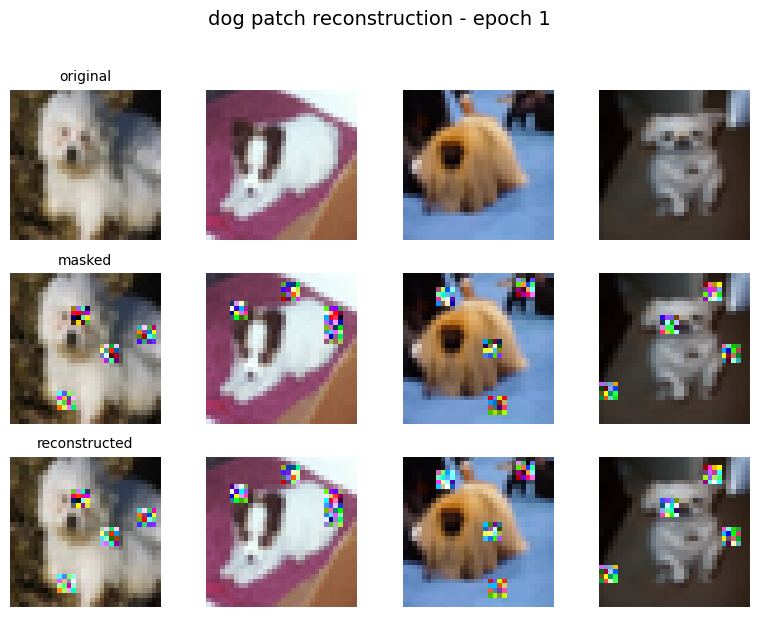

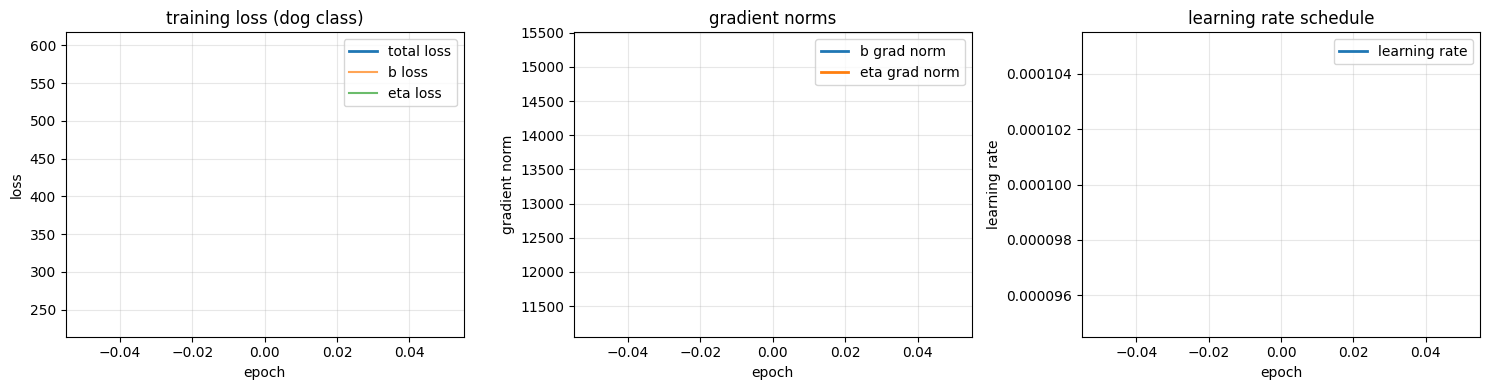

saved checkpoint at epoch 1
[loss: 1.2346s], [backprop: 2.0480s], [update: 0.0752s]
[loss: 0.8780s], [backprop: 1.7149s], [update: 0.0751s]
[loss: 0.8627s], [backprop: 1.7439s], [update: 0.0732s]


KeyboardInterrupt: 

In [23]:
if __name__ == "__main__":
    # we set hyperparameters
    base_lr = 1e-4
    batch_size = 32
    n_epochs = 10000
    patch_size = 4
    num_patches = 4
    metrics_freq = 100
    plot_freq = 500

    print(f"\nhyperparameters:")
    print(f"  class: dog (cifar10 class 5)")
    print(f"  batch_size: {batch_size}")
    print(f"  learning_rate: {base_lr}")
    print(f"  n_epochs: {n_epochs}")
    print(f"  patch_size: {patch_size}")
    print(f"  num_patches: {num_patches}")
    print(f"\nconditioning approach:")
    print(f"  - networks conditioned on binary mask (visible=1, masked=0)")
    print(f"  - visible pixels kept fixed during generation")
    print(f"  - only masked regions are reconstructed")

    # we define interpolant (one-sided linear interpolation)
    path = 'one-sided-linear'
    interpolant = Interpolant(path=path, gamma_type=None)
    print(f"\nusing interpolant: {path}")

    # we define loss functions
    loss_fn_b = make_loss(
        method='shared', interpolant=interpolant, loss_type='one-sided-b'
    )
    loss_fn_eta = make_loss(
        method='shared', interpolant=interpolant, loss_type='one-sided-eta'
    )

    # we create networks
    print("\ncreating u-net architectures with mask conditioning...")
    unet_b = UNetDenoiser(in_channels=5, out_channels=3, base_channels=64)  # we add mask channel
    unet_eta = UNetDenoiser(in_channels=5, out_channels=3, base_channels=64)  # we add mask channel

    b = VelocityNetwork(unet_b).to(get_torch_device())
    eta = EtaNetwork(unet_eta).to(get_torch_device())

    # we count parameters
    n_params_b = sum(p.numel() for p in b.parameters() if p.requires_grad)
    n_params_eta = sum(p.numel() for p in eta.parameters() if p.requires_grad)
    print(f"b network parameters: {n_params_b:,}")
    print(f"eta network parameters: {n_params_eta:,}")

    # we create optimizers and schedulers
    opt_b = torch.optim.Adam(b.parameters(), lr=base_lr)
    opt_eta = torch.optim.Adam(eta.parameters(), lr=base_lr)
    sched_b = torch.optim.lr_scheduler.CosineAnnealingLR(opt_b, T_max=n_epochs, eta_min=base_lr*0.01)
    sched_eta = torch.optim.lr_scheduler.CosineAnnealingLR(opt_eta, T_max=n_epochs, eta_min=base_lr*0.01)

    # we initialize data dictionary
    data_dict = {
        'losses': [],
        'b_losses': [],
        'eta_losses': [],
        'b_grads': [],
        'eta_grads': [],
        'lrs': []
    }

    # we train the model
    print("\nstarting training...\n")
    counter = 1
    for epoch in range(n_epochs):
        loss, b_loss, eta_loss, b_grad, eta_grad = train_step(
            batch_size, interpolant, opt_b, opt_eta, sched_b, sched_eta,
            patch_size, num_patches
        )

        # we log metrics
        if (counter - 1) % metrics_freq == 0:
            data_dict['losses'].append(grab(loss).item())
            data_dict['b_losses'].append(grab(b_loss).item())
            data_dict['eta_losses'].append(grab(eta_loss).item())
            data_dict['b_grads'].append(grab(b_grad).item())
            data_dict['eta_grads'].append(grab(eta_grad).item())
            data_dict['lrs'].append(opt_b.param_groups[0]['lr'])

            print(f"epoch {counter}: loss={grab(loss).item():.4f}, b_loss={grab(b_loss).item():.4f}, eta_loss={grab(eta_loss).item():.4f}")

        # we make plots
        if (counter - 1) % plot_freq == 0:
            make_plots(b, eta, interpolant, counter, data_dict, patch_size, num_patches)

            # we save checkpoints
            torch.save({
                'epoch': counter,
                'b_state_dict': b.state_dict(),
                'eta_state_dict': eta.state_dict(),
                'opt_b_state_dict': opt_b.state_dict(),
                'opt_eta_state_dict': opt_eta.state_dict(),
                'data_dict': data_dict,
                'class': 'dog',
                'class_id': 5
            }, f'dog_checkpoint_epoch_{counter}.pt')
            print(f"saved checkpoint at epoch {counter}")

        counter += 1

    print("\ntraining complete!")